In [1]:
import re
import typing
import numpy as np
import optuna
import pandas as pd

#from category_encoders import CountEncoder
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_percentage_error


from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from catboost import CatBoostClassifier, CatBoostRegressor, Pool, cv
from scipy.stats import gaussian_kde
import shap
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

tqdm.pandas()
shap.initjs()
RANDOM_STATE = 42

# suppress lengthy outputs
import warnings
warnings.simplefilter('ignore')

Mетрика организаторов

In [2]:
THRESHOLD = 0.15
NEGATIVE_WEIGHT = 1.1

def deviation_metric_one_sample(y_true: typing.Union[float, int], y_pred: typing.Union[float, int]) -> float:
    """
    Реализация кастомной метрики для хакатона.

    :param y_true: float, реальная цена
    :param y_pred: float, предсказанная цена
    :return: float, значение метрики
    """
    deviation = (y_pred - y_true) / np.maximum(1e-8, y_true)
    if np.abs(deviation) <= THRESHOLD:
        return 0
    elif deviation <= - 4 * THRESHOLD:
        return 9 * NEGATIVE_WEIGHT
    elif deviation < -THRESHOLD:
        return NEGATIVE_WEIGHT * ((deviation / THRESHOLD) + 1) ** 2
    elif deviation < 4 * THRESHOLD:
        return ((deviation / THRESHOLD) - 1) ** 2
    else:
        return 9


def deviation_metric(y_true: np.array, y_pred: np.array) -> float:
    return np.array([deviation_metric_one_sample(y_true[n], y_pred[n]) for n in range(len(y_true))]).mean()

In [3]:
key_cols = ['id', 'date', 'target', 'log_target', 'price_type', 'train']
adv_key_cols = ['id', 'date', 'month', 'target', 'price_type', 'train']
cat_cols = ['city', 'region', 'realty_type', 'street', 'floor', 'osm_city_nearest_name']
features = []

In [4]:
test = pd.read_csv('../raifhack/test.csv').rename({'per_square_meter_price': 'target'}, axis=1)
train = pd.read_csv('../raifhack/train.csv').rename({'per_square_meter_price': 'target'}, axis=1)

In [5]:
train.shape, test.shape

((279792, 77), (2974, 76))

In [6]:
train.city = train.city.str.replace('ё', 'е')
test.city = test.city.str.replace('ё', 'е')
train.osm_city_nearest_name = train.osm_city_nearest_name.str.replace('ё', 'е')
test.osm_city_nearest_name = test.osm_city_nearest_name.str.replace('ё', 'е')

Проведем Adversarial validation
В данном разделе проверим, насколько сильно наша обучающая выборка отличается от тестовой.

Для этого назовем единичками объекты из обучающей выбокри, ноликами - объекты из тестовой выборки. И на исходных признаках построим модель машинного обучения, которая будет пытаться отличить обучающую выборку от тестовой на основе признаков.

Так как данные распределены по времени, то чтобы оценить качество нашей модели оставим по последнему месяцу из train и test.
Если выборки не отличаются, то качество такой модели должно быть случайной.

Для оценки качества модели будем использовать ROC AUC. Как мы знаем, ROC AUC случайного алгоритма должен быть в районе 0.5.

In [ ]:
test['train'] = 0
train['train'] = 1
adv_dataset = pd.concat([train, test])
adv_dataset = adv_dataset[(adv_dataset.price_type == 1)]

In [ ]:
adv_dataset[cat_cols] = adv_dataset[cat_cols].astype(str).fillna('NAN')
adv_dataset['date'] = pd.to_datetime(adv_dataset['date'])
adv_dataset['month'] = (
    adv_dataset['date'].dt.floor('d') + pd.offsets.MonthEnd(0) - pd.offsets.MonthBegin(1)
)

In [ ]:
oot_train_month_adv = '2020-08-01'
oot_val_month_adv = '2020-12-01'

Xy_train_adv = adv_dataset[~adv_dataset['month'].isin([oot_train_month_adv, oot_val_month_adv])].reset_index(drop=True)
Xy_test_adv = adv_dataset[adv_dataset['month'].isin([oot_train_month_adv, oot_val_month_adv])].reset_index(drop=True)

adv_model = CatBoostClassifier(verbose=100, random_state=RANDOM_STATE)
adv_model.fit(
    Xy_train_adv.drop(adv_key_cols, axis=1), 
    Xy_train_adv['train'],
    cat_features=cat_cols
)

predict_adv = adv_model.predict(Xy_test_adv.drop(adv_key_cols, axis=1))

print("ROC AUC score : %f" % roc_auc_score(Xy_test_adv['train'], predict_adv))

Удалим выбросы, которые вносят шум в target

In [ ]:
# Оценим изначальное распределение цен по регионам
f, ax = plt.subplots(figsize=(25, 10))
plt.xticks(rotation=90)
sns.violinplot(x="region", y="target", data=train)

In [7]:
# Удалим выбросы за 1 и 99 перцентилем
def is_outlier(s):
    lower_limit = s.quantile(.01)
    upper_limit = s.quantile(.99)
    return ~s.between(lower_limit, upper_limit)

train = train[~train.groupby('region')['target'].apply(is_outlier)]

<AxesSubplot:xlabel='region', ylabel='target'>

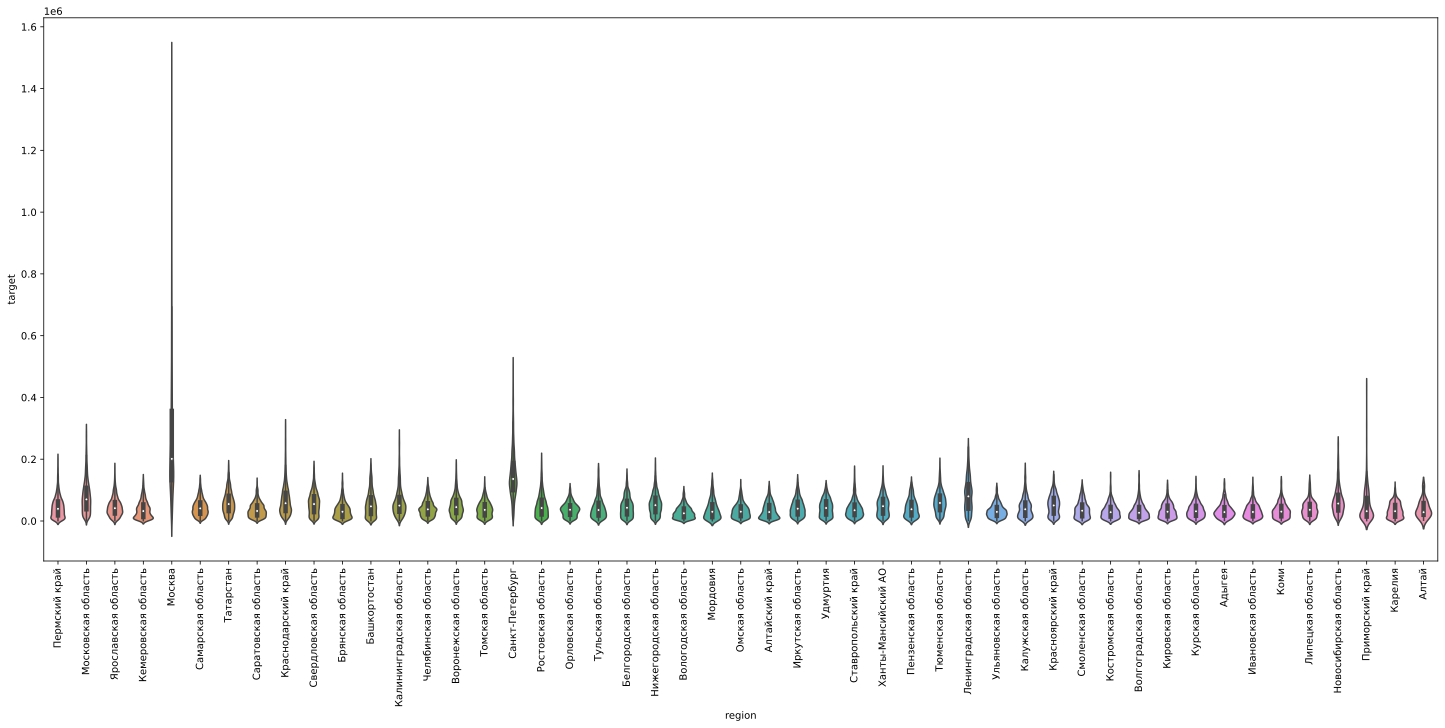

In [8]:
# Проверим получившееся распределение цен по регионам
f, ax = plt.subplots(figsize=(25, 10))
plt.xticks(rotation=90)
sns.violinplot(x="region", y="target", data=train)

Определение коррелирующих фичей

In [9]:
# вручную удалил повторяющиеся признаки с разным метражом, оставив только значение 
# "in 0.01" для osm и "1000" для reform
columns_for_pearson = [
                       'target', 
                       'city', 
                       'floor',
                       'osm_amenity_points_in_0.01', 
                       'osm_building_points_in_0.01', 
                       'osm_catering_points_in_0.01', 
                       'osm_city_closest_dist',  
                       'osm_city_nearest_population',
                       'osm_crossing_closest_dist', 
                       'osm_crossing_points_in_0.01', 
                       'osm_culture_points_in_0.01',
                       'osm_healthcare_points_in_0.01', 
                       'osm_historic_points_in_0.01', 
                       'osm_hotels_points_in_0.01',
                       'osm_leisure_points_in_0.01', 
                       'osm_offices_points_in_0.01', 
                       'osm_shops_points_in_0.01', 
                       'osm_subway_closest_dist',
                       'osm_train_stop_closest_dist', 
                       'osm_train_stop_points_in_0.01', 
                       'osm_transport_stop_closest_dist',
                       'osm_transport_stop_points_in_0.01', 
                       'reform_count_of_houses_1000', 
                       'reform_house_population_1000',
                       'reform_mean_floor_count_1000', 
                       'reform_mean_year_building_1000', 
                       'region', 
                       'total_square', 
                       'street', 
                       'date', 
                       'realty_type', 
                       'price_type'
]

In [10]:
# Находим признаки, имеющие максимальное значение коэффициента корреляции Пирсона с целевой переменной. 
# В качестве отсечки выбрано значение 0.4 по модулю
pearson = train[columns_for_pearson].corr().round(2)
pearson_max_corr = (
    pearson['target'].to_frame().reset_index()
    .rename(columns={'target':'pearson', 'index':'feature'})
    .sort_values(by='pearson', ascending=False)
    .query('pearson > 0.4 or pearson < -0.4')
)

features.extend(pearson_max_corr['feature'].values.tolist()[1:])
pearson_max_corr

,feature,pearson
0,target,1.00
5,osm_city_nearest_population,0.60
1,osm_amenity_points_in_0.01,0.49
12,osm_leisure_points_in_0.01,0.49
9,osm_healthcare_points_in_0.01,0.48
3,osm_catering_points_in_0.01,0.48
19,osm_transport_stop_points_in_0.01,0.46
14,osm_shops_points_in_0.01,0.46
7,osm_crossing_points_in_0.01,0.45
13,osm_offices_points_in_0.01,0.44


Генерация дополнительных фичей

Проверим распределение целевой переменной в датасетах

In [ ]:
sns.distplot(train['target'])

Так как target имеет явно распределение отличное от нормального, логарифмируем target, 
что позволит повысить точность предсказания. 

<AxesSubplot:xlabel='log_target', ylabel='Density'>

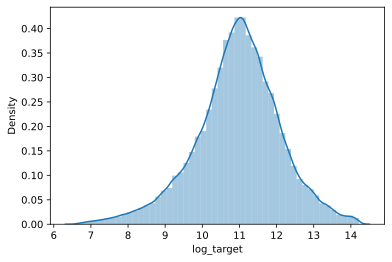

In [11]:
train['log_target'] = np.log(train['target'])
sns.distplot(train['log_target'])

In [12]:
# Добавление дополнительных статистических данных 
city_population = pd.read_csv('../raifhack/city_population.csv')
zarplaty = pd.read_csv('../raifhack/zarplaty.csv', sep = ';')

def city_type(row):
    if row >=1000000:
        return "1Million"
    elif  (row<1000000)&(row >200000):
        return "Medium"
    elif  (row <=200000):
        return "Small"
     
def add_features(df):
    df['age'] = round(2021 - df['reform_mean_year_building_500'])
    df.city = df.city.apply(lambda x: x.lower())
    
    city_population_clean = city_population.groupby('settlement').agg({'population':'sum'}).reset_index()
    city_population_clean.columns = ['city', 'city_population']
    city_population_clean['city_population']
    city_population_clean.city = city_population_clean.city.apply(lambda x: x.lower())
    df = df.merge(city_population_clean, on = 'city', how='left')
    
    for col in df.select_dtypes(include=np.number).columns:
        df[col] = pd.to_numeric(df[col], downcast = 'unsigned')
    
    df['city_type'] = df['city_population'].apply(lambda x: city_type(x))
    df.loc[df.city  == 'москва', 'city_type'] = "Capital"
    df.loc[df.city  == 'санкт-Петербург', 'city_type'] = "Capital"
    
    df = df.merge(zarplaty, on = 'region', how='left')
    df['zarplata'] = pd.to_numeric(df['zarplata'], downcast = 'unsigned')
     
    return df

In [13]:
train = add_features(train)
test = add_features(test)

cat_cols.append('city_type')
features.extend(['city_population', 'zarplata'])

Предобработка фичи этаж

In [14]:
#Ручная обработка столбца с этажами
basement = ['подва', 'цоколь', 'тех']
r = re.compile('[0-9]+')

def parse_floor(x):
    if not isinstance(x, str) and np.isnan(x):
        return np.nan
    x = str(x).strip().replace('этаж', '').replace('-й', '').replace('цоколь', '-1').replace('подвал', '-1')
    try:
        return int(float(x))
    except ValueError:
        x = np.mean([int(y) for y in r.findall(x)])
        return x
  
for df in [train, test]:
    # Обработаем отдельную категорию этажности объектов
    df['basement'] = df['floor'].map(lambda x: any(y in str(x) for y in basement))
    # Подсчитаем количество этажей на объектах (для NaN примем как минимум 1 этаж)
    df['floor_count'] = df['floor'].map(lambda x: str(x).count(',') + str(x).count('+') + 1)
    df['floor'] = df['floor'].map(parse_floor)

cat_cols.append('basement')
features.append('floor_count')

Обучение K-means модели и добавление кластера как фактора
- кластеризация на широте и долготе
- кластеризация на osm-факторах

In [ ]:
# Выясним сколько кластеров необходимо
inertia = []
for k in tqdm(range(250, 800, 25)):
    km = MiniBatchKMeans(n_clusters=k).fit(train[['lat', 'lng']])
    inertia.append(np.sqrt(km.inertia_))

plt.plot(range(250, 800, 25), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [15]:
# Примем 700 кластеров
km = MiniBatchKMeans(n_clusters=700, batch_size=1_000, random_state=RANDOM_STATE)
km.fit(train[['lat', 'lng']])

train['cluster_id'] = km.predict(train[['lat', 'lng']])
test['cluster_id'] = km.predict(test[['lat', 'lng']])

cat_cols.append('cluster_id')

In [ ]:
# Выясним сколько кластеров необходимо для osm-фактора
inertia_osm = []
osm_features = [x for x in columns_for_pearson if x.startswith('osm_') or x.startswith('reform_')]
sc = StandardScaler()

for k in tqdm(range(1, 5)):
    km_osm = MiniBatchKMeans(n_clusters=k, batch_size=1_000)
    km_osm.fit(sc.fit_transform(train[osm_features].fillna(0)))
    inertia_osm.append(np.sqrt(km.inertia_))

plt.plot(range(1, 5), inertia_osm, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

In [16]:
osm_features = [x for x in columns_for_pearson if x.startswith('osm_') or x.startswith('reform_')]
sc = StandardScaler()
km_osm = MiniBatchKMeans(n_clusters=7, batch_size=1_000, random_state=RANDOM_STATE)
km_osm.fit(sc.fit_transform(train[osm_features].fillna(0)))

train['cluster_osm_id'] = km_osm.predict(sc.transform(train[osm_features].fillna(0)))
test['cluster_osm_id'] = km_osm.predict(sc.transform(test[osm_features].fillna(0)))

cat_cols.append('cluster_osm_id')

Добавим дополнительные фичи по характеристикам объектов

In [17]:
# Подсчитаем дополнительные характеристики объектов
train['total_square/floor_count'] = train['total_square'] / train['floor_count']
train['floor_count/total_square'] = train['floor_count'] / train['total_square']

test['total_square/floor_count'] = test['total_square'] / test['floor_count']
test['floor_count/total_square'] = test['floor_count'] / test['total_square']

features.extend(['total_square/floor_count', 'floor_count/total_square'])

Заполним пропуски

In [18]:
train[cat_cols] = train[cat_cols].astype(str).fillna('__NAN__')
test[cat_cols] = test[cat_cols].astype(str).fillna('__NAN__')

In [ ]:
# Не получилось использовать, так как по некоторым регионам данных нет
def impute_numerical(df, categorical_column, numerical_column):
    frames = []
    for i in list(set(df[categorical_column])):
        df_category = df[df[categorical_column] == i]
        if len(df_category) > 1:    
            df_category[numerical_column].fillna(df_category[numerical_column].median(),inplace = True)        
        else:
            df_category[numerical_column].fillna(df[numerical_column].median(),inplace = True)
        frames.append(df_category)    
        final_df = pd.concat(frames)
    return final_df

train  = impute_numerical(train, 'region', 'zarplata')
test  = impute_numerical(test, 'region', 'zarplata')

In [19]:
train[features] = train[features].fillna('-10')
test[features] = test[features].fillna('-10')

In [20]:
selected_features = cat_cols + features

Выделим валидационную выборку на трейне, чтобы оценивать качество различных подходов

<AxesSubplot:title={'center':"Кол-во объектов по месяцам на train'e"}>

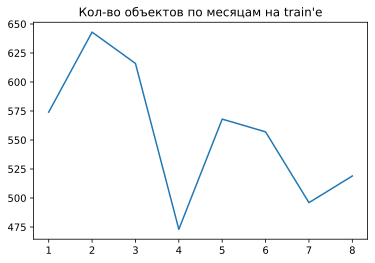

In [21]:
train['date'] = pd.to_datetime(train['date'])
train['month'] = train['date'].dt.month
train[train.price_type == 1]['month'].value_counts().sort_index().plot(
    title="Кол-во объектов по месяцам на train'e")

Разделим обучающую выборку на train и validation

In [22]:
val_month = '8'
validation = train[(train['month'] == 8) & (train.price_type == 1)].copy()
train_val = pd.concat([train,validation]).drop_duplicates(keep=False).copy()

In [23]:
train.shape, train_val.shape, validation.shape

((274343, 89), (273824, 89), (519, 89))

Разделим обучающую выборку на ручную разметку и цену объявлений

In [24]:
manual = train_val[(train_val.city.isin(set(test.city))) & (train_val.price_type == 1)].reset_index(drop=True)
auto = train_val[(train_val.city.isin(set(test.city))) & (train_val.price_type == 0)].reset_index(drop=True)

Подберем гиперпараметры через Optuna

In [ ]:
def objective(trial):
    data, target = auto[selected_features], auto['log_target']
    X_train, X_valid, y_train, y_valid = train_test_split(data, target, test_size=0.2)
    
    param = {
        'iterations': 1700,
        'grow_policy': 'Lossguide',
        'od_wait': 300,
        'depth' : trial.suggest_int("depth", 3, 10),
        'learning_rate' : trial.suggest_uniform('learning_rate', 0.0000001, 0.5),
        'bootstrap_type' : trial.suggest_categorical('bootstrap_type', ['Bayesian', 'MVS']),
        'loss_function' : trial.suggest_categorical('loss_function', ['RMSE', 'MAE']),
        'eval_metric': trial.suggest_categorical('eval_metric', ['RMSE', 'MAE']),
        'l2_leaf_reg' : trial.suggest_uniform('l2_leaf_reg', 4, 5),
        'random_strength' : trial.suggest_uniform('random_strength', 4, 8),
    }
    
    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
        
    gbm = CatBoostRegressor(**param, cat_features=cat_cols)
    gbm.fit(X_train, y_train, 
            eval_set=[(X_valid, y_valid)], 
            verbose=0, early_stopping_rounds=100)
    preds = gbm.predict(X_valid)
    return mean_squared_error(y_valid, preds)

In [ ]:
catboost_study = optuna.create_study(direction='minimize')
catboost_study.optimize(objective, n_trials=50)

print('Number of finished trials:', len(catboost_study.trials))
print('Best trial: score {}, params {}'.format(catboost_study.best_trial.value, catboost_study.best_trial.params))

In [25]:
# На основании оптимизации библиотеки Optuna используем следующие параметры для Catboost'a
params = {
        'iterations': 1700,
        'bootstrap_type': 'MVS',
        'od_wait': 300,
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'logging_level': 'Silent',
        'depth': 8,
        'l2_leaf_reg': 4.239948384265954,
        'langevin': False,
        'learning_rate': 0.4194983689588455,
        'random_strength': 4.759010376756083,
        'rsm': 0.4199438024187796
    }

In [26]:
auto.shape, manual.shape

((210472, 89), (3817, 89))

In [27]:
# Обучим CatBoost на price_type == 0 на 10 фолдах. Дообучим CatBoost на price_type == 1 на 10 фолдах. 
# На каждом фолде модели верхнего порядка будем предиктить усредненный target для тестовой выборки

kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
validation['prediction_clf_1'] = 0

for train_idx, valid_idx in tqdm(kf.split(auto[selected_features]), total=kf.n_splits):
    train_pool = Pool(auto.loc[train_idx, selected_features], auto.loc[train_idx, 'log_target'],
                               cat_features=cat_cols)
    valid_pool = Pool(auto.loc[valid_idx, selected_features], auto.loc[valid_idx, 'log_target'],
                               cat_features=cat_cols)
    clf_1 = CatBoostRegressor(**params)
    clf_1.fit(train_pool, eval_set=valid_pool) 
    
for train_idx, valid_idx in tqdm(kf.split(manual[selected_features]), total=kf.n_splits):
    train_pool = Pool(manual.loc[train_idx, selected_features], manual.loc[train_idx, 'log_target'],
                               cat_features=cat_cols)
    valid_pool = Pool(manual.loc[valid_idx, selected_features], manual.loc[valid_idx, 'log_target'],
                               cat_features=cat_cols)
    clf_1.fit(train_pool, eval_set=valid_pool)
    validation['prediction_clf_1'] += clf_1.predict(validation[selected_features]) / kf.n_splits

# Предиктим на валидации, чтобы оценить качество модели    
validation['prediction_clf_1'] = np.exp(validation['prediction_clf_1'])
print('Catboost MSE for 1 approach: ', mean_squared_error(validation['target'], 
                                                          validation['prediction_clf_1'], squared=False))
print('Catboost MAPE for 1 approach: ', mean_absolute_percentage_error(validation['target'], 
                                                                       validation['prediction_clf_1']))
print('Raif metric for 1 approach: ', deviation_metric(validation['target'].values, 
                                                       validation['prediction_clf_1'].values))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Catboost MSE for 1 approach:  27427.056522060313
Catboost MAPE for 1 approach:  0.3035914173144911
Raif metric for 1 approach:  1.2832473017369959


Далее используется ядерная оценка плотности (англ. Kernel Density Estimation, KDE) —  непараметрический способ оценки плотности случайной величины. Ядерная оценка плотности является задачей сглаживания данных, когда делается заключение о совокупности, основываясь на конечных выборках данных.
После реализованы множественныя извлечениях подвыборок из обучающей выборки.

Text(0.5, 0, 'log_target')

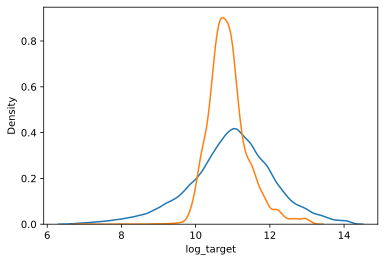

In [28]:
# Проверим распределение целевой переменной на ручной разметке цен и ценах объялений
train.groupby('price_type')['log_target'].apply(lambda x: sns.distplot(x, 
                                                                       hist=False, 
                                                                       rug=False,label = x.name))
plt.xlabel('log_target')

In [29]:
def get_sampled_train(train_1, train_0, sample_fraq=0.5):
    choice_idx = np.random.choice(range(train_0.shape[0]), size=int(train_0.shape[0] / 2),
                                  replace=False, p=probs / sum(probs))
    train_0 = train_0.iloc[choice_idx].reset_index(drop=True)
    return pd.concat([train_0, train_1]).reset_index(drop=True)

train_0 = train_val[train_val.price_type == 0].reset_index(drop=True)
train_1 = train_val[train_val.price_type == 1].reset_index(drop=True)
train_0['log_target'] = train_0['log_target'] * train_1.log_target.mean() / train_0.log_target.mean()
kde = gaussian_kde(train_1.log_target)
probs = kde(train_0.log_target)

In [30]:
validation['prediction_clf_2'] = 0
n_iter = 25

for i in tqdm(range(n_iter)):
    current_train = get_sampled_train(train_1, train_0)
    train_pool = Pool(current_train[selected_features], current_train['log_target'],
                      cat_features=cat_cols)
    clf_2 = CatBoostRegressor(**params)
    clf_2.fit(train_pool) 
    validation['prediction_clf_2'] += clf_2.predict(validation[selected_features]) / n_iter

# Предиктим на валидации, чтобы оценить качество модели    
validation['prediction_clf_2'] = np.exp(validation['prediction_clf_2'])
print('Catboost MSE for 2 approach: ', mean_squared_error(validation['target'], 
                                                          validation['prediction_clf_2'], squared=False))
print('Catboost MAPE for 2 approach: ', mean_absolute_percentage_error(validation['target'], 
                                                                       validation['prediction_clf_2']))
print('Raif metric for 2 approach: ', deviation_metric(validation['target'].values, 
                                                       validation['prediction_clf_2'].values))

  0%|          | 0/25 [00:00<?, ?it/s]

Catboost MSE for 2 approach:  24848.69683980928
Catboost MAPE for 2 approach:  0.29478492959411023
Raif metric for 2 approach:  1.1394435093711304


Добавление дополнительной OOF meta-feature на предсказаниях цены построенной по автоматическсим оценкам.

In [76]:
# Обучим CatBoost на price_type == 0 на 10 фолдах и усредним их предсказания для price_type == 1,
# получим доп.фичу predict_0 для обучающей выборки с ручной разметкой

kf = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE+1)
manual['prediction_0'] = 0
validation['prediction_0'] = 0
validation['prediction_clf_3'] = 0

for train_idx, valid_idx in tqdm(kf.split(auto['log_target']), total=kf.n_splits):
    train_pool = Pool(auto.loc[train_idx, selected_features], auto.loc[train_idx, 'log_target'],
                               cat_features=cat_cols)
    valid_pool = Pool(auto.loc[valid_idx, selected_features], auto.loc[valid_idx, 'log_target'],
                               cat_features=cat_cols)
    clf_3 = CatBoostRegressor(**params)
    clf_3.fit(train_pool, eval_set=valid_pool) 
    manual['prediction_0'] += clf_3.predict(manual[selected_features]) / kf.n_splits
    validation['prediction_0'] += clf_3.predict(validation[selected_features]) / kf.n_splits

manual['prediction_0'] = np.exp(manual['prediction_0'])
validation['prediction_0'] = np.exp(validation['prediction_0'])
selected_features.append('prediction_0')

for train_idx, valid_idx in tqdm(kf.split(manual['log_target']), total=kf.n_splits):
    train_pool = Pool(manual.loc[train_idx, selected_features], manual.loc[train_idx, 'log_target'],
                               cat_features=cat_cols)
    valid_pool = Pool(manual.loc[valid_idx, selected_features], manual.loc[valid_idx, 'log_target'],
                               cat_features=cat_cols)
    clf_4 = CatBoostRegressor(**params)
    clf_4.fit(train_pool, eval_set=valid_pool) 
    validation['prediction_clf_3'] += clf_4.predict(validation[selected_features]) / kf.n_splits

# Предиктим на валидации, чтобы оценить качество модели    
validation['prediction_clf_3'] = np.exp(validation['prediction_clf_3'])
print('Catboost MSE for 3 approach: ', mean_squared_error(validation['target'], 
                                                          validation['prediction_clf_3'], squared=False))
print('Catboost MAPE for 3 approach: ', mean_absolute_percentage_error(validation['target'], 
                                                                       validation['prediction_clf_3']))
print('Raif metric for 3 approach: ', deviation_metric(validation['target'].values, 
                                                       validation['prediction_clf_3'].values))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Catboost MSE for 3 approach:  27120.193598990387
Catboost MAPE for 3 approach:  0.29250377201508315
Raif metric for 3 approach:  1.3015157117539575


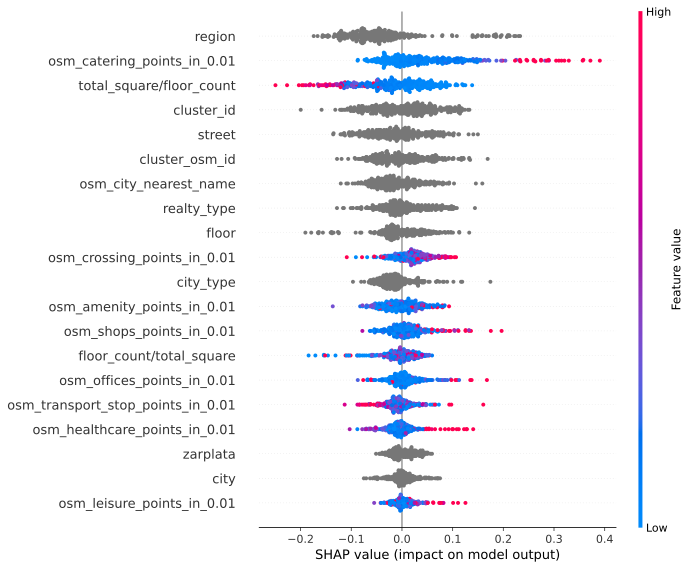

In [86]:
explainer = shap.TreeExplainer(clf_2)
shap_values = explainer.shap_values(valid_pool)
shap.summary_plot(shap_values, manual.loc[valid_idx, selected_features])

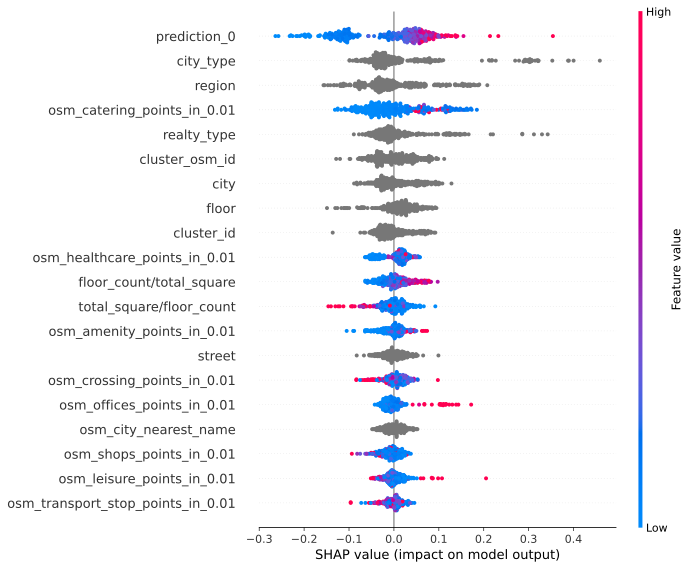

In [84]:
explainer = shap.TreeExplainer(clf_4)
shap_values = explainer.shap_values(valid_pool)
shap.summary_plot(shap_values, manual.loc[valid_idx, selected_features])

In [77]:
# Проверим метрики на локальной валидации
for i in range(1, 4):
    print(f'RMSE for {i} approach: ', 
          mean_squared_error(validation['target'],
                             validation[f'prediction_clf_{i}'], squared=False))
    print(f'MAPE for {i} approach: ', 
          mean_absolute_percentage_error(validation['target'], 
                                         validation[f'prediction_clf_{i}']))
    print(f'Raif metric for {i} approach: ', 
          deviation_metric(validation['target'].values,
                           validation[f'prediction_clf_{i}'].values))
    print('')

Catboost RMSE for 1 approach:  27427.056522060313
Catboost MAPE for 1 approach:  0.3035914173144911
Raif metric for 1 approach:  1.2832473017369959

Catboost RMSE for 2 approach:  24848.69683980928
Catboost MAPE for 2 approach:  0.29478492959411023
Raif metric for 2 approach:  1.1394435093711304

Catboost RMSE for 3 approach:  27120.193598990387
Catboost MAPE for 3 approach:  0.29250377201508315
Raif metric for 3 approach:  1.3015157117539575



In [81]:
# Введем ручную поправку на дисконт равную 0.93 для финальных предиктов каждой из моделей
DISCOUNT = 0.93
for i in range(1, 4):
    validation[f'prediction_clf_{i}_corr'] = validation[f'prediction_clf_{i}'] * DISCOUNT

# Проверим метрики скорректированных предиктов на локальной валидации
for i in range(1, 4):
    print(f'corrected RMSE for {i} approach: ', 
          mean_squared_error(validation['target'],
                             validation[f'prediction_clf_{i}_corr'], squared=False))
    print(f'corrected MAPE for {i} approach: ', 
          mean_absolute_percentage_error(validation['target'], 
                                         validation[f'prediction_clf_{i}_corr']))
    print(f'corrected Raif metric for {i} approach: ', 
          deviation_metric(validation['target'].values,
                           validation[f'prediction_clf_{i}_corr'].values))
    print('')

corrected RMSE for 1 approach:  28681.16989452668
corrected MAPE for 1 approach:  0.288877991947674
corrected Raif metric for 1 approach:  1.1834638022477737

corrected RMSE for 2 approach:  26788.745704258854
corrected MAPE for 2 approach:  0.28018119479421
corrected Raif metric for 2 approach:  1.014534564249327

corrected RMSE for 3 approach:  28259.56020909707
corrected MAPE for 3 approach:  0.28154301063878423
corrected Raif metric for 3 approach:  1.200640543975117



Лучше всех себя показало сэмплирование через ядерную оценку плотности распределений объектов по price_type - наилучший скор на локальной валидации. Именно этот метод используем для финального сабмита.